In [1]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import namedtuple

In [2]:
#read calibration parms
def load_camera_param(camera):
    fs = cv2.FileStorage(f"yaml/{camera}.yaml", cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("dist_coeffs").mat()
    resolution = fs.getNode("resolution").mat().reshape(2).tolist()
    project_matrix = fs.getNode("project_matrix").mat()
    scale_xy = fs.getNode("scale_xy").mat().reshape(2).tolist()
    shift_xy = fs.getNode("shift_xy").mat().reshape(2).tolist()
    
    shapes = {
        "front": [1200, 550],
        "back": [1200, 550],
        "left": [1600, 500],
        "right": [1600, 500],
    }
    
    oris = {
        "front": "n",
        "left": "r-",
        "back": "m",
        "right": "r+"
    }
    
    class_name = namedtuple("CameraParam", ["camera_matrix", "dist_coeffs", "resolution", "project", "scale", "shift",  "shape", "ori"])
    return class_name(camera_matrix, dist_coeffs, resolution, project_matrix, scale_xy, shift_xy, shapes[camera], oris[camera])


def get_rotation_matrix(theta, w, h):
    
    horizontal = theta % 180 == 0
    theta = theta / 180 * np.pi
    R90 = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    if horizontal:
        To = np.array([
            [1, 0, -w*0.5],
            [0, 1, -h*0.5],
            [0, 0, 1]
        ])

        Tn = np.array([
            [1, 0, w*0.5],
            [0, 1, h*0.5],
            [0, 0, 1]
        ])
        return Tn @ R90 @ To
    else:
        To = np.array([
            [1, 0, -w*0.5],
            [0, 1, -h*0.5],
            [0, 0, 1]
        ])

        Tn = np.array([
            [1, 0, h*0.5],
            [0, 1, w*0.5],
            [0, 0, 1]
        ])
        return Tn @ R90 @ To

def rotation(operator, shape):
    if operator == "r+":
        return get_rotation_matrix(90, shape[0], shape[1]), shape[::-1]
    elif operator == "r-":
        return get_rotation_matrix(-90, shape[0], shape[1]), shape[::-1]
    elif operator == "m":
        return get_rotation_matrix(180, shape[0], shape[1]), shape
    return np.eye(3), shape

In [3]:
cameras = ["front", "left", "back", "right"]
camera_params = {}
images = {}
for camera in cameras:
    camera_params[camera] = load_camera_param(camera) 
    images[camera] = cv2.imread(f"images/{camera}.png")
    
weights = cv2.imread("yaml/weights.png", -1) / 255

SW = 1200
SH = 1600

In [4]:
table = []
for camera in cameras:
    image = images[camera]
    param = camera_params[camera]
    
    scaled_camera_matrix = param.camera_matrix.copy()
    scaled_camera_matrix[[0, 1], [0, 1]] *= param.scale
    scaled_camera_matrix[:2, 2] += param.shift
    x, y = cv2.fisheye.initUndistortRectifyMap(param.camera_matrix, param.dist_coeffs, None, scaled_camera_matrix, param.resolution, cv2.CV_32F)
    undistorted_image = cv2.remap(image, x, y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    IH, IW = undistorted_image.shape[:2]
    proj, shape = rotation(param.ori, param.shape)
    w, h = shape
    ys, xs = torch.meshgrid(torch.arange(h), torch.arange(w))
    xy = torch.stack([xs + 0.5, ys + 0.5, torch.ones_like(xs)], dim=-1).float()

    xy = xy @ torch.from_numpy(proj @ param.project).float().inverse().T
    xy[..., :2] /= xy[..., [2]]
    xy = ((xy[..., :2] - 0.5) / torch.tensor([IW, IH]))[None] * 2 - 1
    remapxy = torch.stack([torch.from_numpy(x) + 0.5, torch.from_numpy(y) + 0.5], dim=-1)
    output = F.grid_sample(remapxy.permute(2, 0, 1)[None], xy.float(), "bilinear", align_corners=False)[0].permute(1, 2, 0)
    if camera == "left":
        cx = w
        cy = h / 2
        M = np.array([
            [1, 0, -cx + w],
            [0, 1, -cy + SH / 2]
        ])
    elif camera == "right":
        cx = 0
        cy = h / 2
        M = np.array([
            [1, 0, -cx + SW - w],
            [0, 1, -cy + SH / 2]
        ])
    elif camera == "front":
        cx = w / 2
        cy = h
        M = np.array([
            [1, 0, -cx + SW / 2],
            [0, 1, -cy + h]
        ])
    elif camera == "back":
        cx = w / 2
        cy = 0
        M = np.array([
            [1, 0, -cx + SW / 2],
            [0, 1, -cy + SH - h]
        ])
    output_coord = cv2.warpAffine(output.data.numpy(), M, dsize=(SW, SH), flags=cv2.INTER_NEAREST)
    output_coord[..., 0] = output_coord[..., 0].clip(0, IW-1)
    output_coord[..., 1] = output_coord[..., 1].clip(0, IH-1)
    table.append(output_coord)

/home/zyy/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
front, left, back, right = table
# -1 none
# 0, 1, 2, 3  camera idxs
flags = np.full((SH, SW, 1), -1)  
flags[front[..., 0] != 0] = 0
flags[left[..., 0] != 0]  = 1
flags[back[..., 0] != 0]  = 2
flags[right[..., 0] != 0] = 3
weight_map = np.zeros((SH, SW, 1))
for i in range(4):
    
    weight = weights[..., i]
    wH, wW = weight.shape[:2]
    
    x, y = [
        [0, SH - wH],
        [SW - wW, 0],
        [0, 0],
        [SW - wW, SH - wH]
    ][i]
    flags[y:y+wH, x:x+wW, 0] = [
        4,  # 4 -> 2, 1
        5,  # 5 -> 0, 3
        6,  # 6 -> 0, 1
        7,  # 7 -> 2, 3
    ][i]
    weight_map[y:y+wH, x:x+wW, 0] = weight
    
table = np.concatenate([flags, weight_map] + table, axis=-1)
table.astype(np.float32).tofile("surround_view.binary")
    

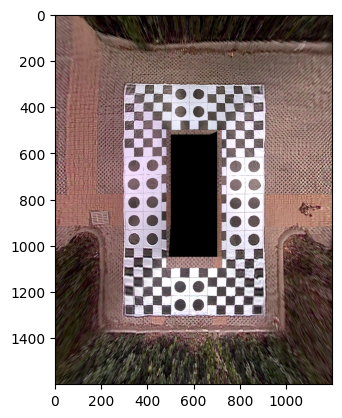

In [6]:
scenes = np.zeros((SH, SW, 3), dtype=np.uint8)
idxs = [[2, 1], [0, 3], [0, 1], [2, 3]]

for y in range(SH):
    for x in range(SW):
        item = table[y, x]
        flag, weight = item[:2]
        flag = int(flag)
        
        if flag == -1:
            continue
            
        if flag < 4:
            image = images[cameras[flag]]
            px, py = item[2 + flag * 2:2 + flag * 2 + 2].astype(np.int32)
            scenes[y, x] = image[py, px]
        else:
            a, b = idxs[flag - 4]
            apx, apy = item[2 + a * 2:2 + a * 2 + 2].astype(np.int32)
            bpx, bpy = item[2 + b * 2:2 + b * 2 + 2].astype(np.int32)
            scenes[y, x] = images[cameras[a]][apy, apx] * weight + images[cameras[b]][bpy, bpx] * (1 - weight)
            
plt.imshow(scenes[..., ::-1])

In [ ]:
#compile
!/usr/local/cuda/bin/nvcc cuda.cu -o cuda `pkg-config --cflags --libs opencv4`
#!nvcc cuda.cu -o cuda -lopencv_core -lopencv_imgcodecs

In [8]:
#run 
!./cuda

hello 960 x 640
